+ __说明:__

本程序是 阿里云天池 的比赛 津南数字制造算法挑战赛(赛场一) 初赛 17 名的复赛程序，包括了收率预测、和参数生成。
队伍名称 Drop, 作者: 陶亚凡 陕西科技大学     队友：Blue 电子科技大学

+ __收率预测：__

与初赛类似，单有所改动，改动如下：

（1）最终异常数据并没有用其他特征来预测，只是简单的改变为缺失值，最后发现效果甚至好于用其他特征预测。

（2）未使用 id 特征。

（3）经过多次特征选择最终决定用 9 个特征，因此略去了特征选择的过程。

+ __最优参数生成：__

测试了两种方法，并最终采用粒子群算法：

（1）梯度下降：通过数值方法计算每个特征的梯度，然后按照梯度下降的方法更新参数，但是最终发现梯度下降对于树模型基本没用，猜测因为特征略微改变后不影响分裂后的结果，因此大部分时候梯度为 0。

（2）粒子群算法：每个粒子代表一组参数，优化目标为最优参数，寻找最优的粒子。并测试了不同的参数，确保找到最优的参数。

# 导入包，读取数据

In [1]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import lightgbm as lgb
import xgboost as xgb
from scipy import sparse
import warnings
import time
import sys
import os
import re
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go 
import plotly.tools as tls
from xgboost import XGBRegressor
from tpot import TPOTRegressor

/usr/local/lib/python3.6/dist-packages/deap/tools/_hypervolume/pyhv.py:33: ImportWarning:

Falling back to the python version of hypervolume module. Expect this to be very slow.

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__

/usr/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning:

Not importing directory /usr/local/lib/python3.6/dist-packages/mpl_toolkits: missing __init__

/usr/lib/python3.6/importlib/_bootstrap_external.py:426: ImportWarning:

Not importing directory /usr/local/lib/python3.6/dist-packages/google: missing __init__



In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RepeatedKFold, ShuffleSplit
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import Imputer
from scipy.stats import skew
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



In [3]:
py.init_notebook_mode(connected=True)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

## 设定文件名, 读取文件

In [4]:
train_file_name = 'data/jinnan_round1_train_20181227.csv'
test_file_name = 'data/jinnan_round1_testB_20190121.csv'
test_name = 'B'

In [5]:
# 读取数据， 改名
train = pd.read_csv(train_file_name, encoding = 'gb18030')
test  = pd.read_csv(test_file_name, encoding = 'gb18030')
train.rename(columns={'样本id':'id', '收率':'target'}, inplace = True)
test.rename(columns={'样本id':'id', '收率':'target'}, inplace = True)
target_name = 'target'

# 存在异常数据，改为 nan
train.loc[1304, 'A25'] = np.nan
train['A25'] = train['A25'].astype(float)

# 去掉 id 前缀
train['id'] = train['id'].apply(lambda x: int(x.split('_')[1]))
test['id'] = test['id'].apply(lambda x: int(x.split('_')[1]))

train.drop(train[train[target_name] < 0.87].index, inplace=True)
full=pd.concat([train, test], ignore_index=True)

# 数据清洗

## 删除缺失率高的特征

+ __删除缺失值大于 th_high 的值__
+ __缺失值在 th_low 和 th_high 之间的特征根据是否缺失增加新特征__
  
  如 B10 缺失较高，增加新特征 B10_null，如果缺失为1，否则为0

In [6]:
class del_nan_feature(BaseEstimator, TransformerMixin):
    
    def __init__(self, th_high=0.85, th_low=0.02):
        self.th_high = th_high
        self.th_low = th_low
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'del_nan_feature', ' '*5, '-'*30, '\n')
        print("shape before process = {}".format(X.shape))

        # 删除高缺失率特征
        X.dropna(axis=1, thresh=(1-self.th_high)*X.shape[0], inplace=True)
        
        
        # 缺失率较高，增加新特征
        for col in X.columns:
            if col == 'target':
                continue
            
            miss_rate = X[col].isnull().sum()/ X.shape[0]
            if miss_rate > self.th_low:
                print("Missing rate of {} is {:.3f} exceed {}, adding new feature {}".
                     format(col, miss_rate, self.th_low, col+'_null'))
                X[col+'_null'] = 0
                X.loc[X[pd.isnull(X[col])].index, [col+'_null']] = 1
        print("shape = {}".format(X.shape))

        return X

## 处理字符时间（段）

In [7]:
# 处理时间
def timeTranSecond(t):
    try:
        h,m,s=t.split(":")
    except:

        if t=='1900/1/9 7:00':
            return 7*3600/3600
        elif t=='1900/1/1 2:30':
            return (2*3600+30*60)/3600
        elif pd.isnull(t):
            return np.nan
        else:
            return 0

    try:
        tm = (int(h)*3600+int(m)*60+int(s))/3600
    except:
        return (30*60)/3600

    return tm

In [8]:
# 处理时间差
def getDuration(se):
    try:
        sh,sm,eh,em=re.findall(r"\d+",se)
#         print("sh, sm, eh, em = {}, {}, {}, {}".format(sh, em, eh, em))
    except:
        if pd.isnull(se):
            return np.nan, np.nan, np.nan

    try:
        t_start = (int(sh)*3600 + int(sm)*60)/3600
        t_end = (int(eh)*3600 + int(em)*60)/3600
        
        if t_start > t_end:
            tm = t_end - t_start + 24
        else:
            tm = t_end - t_start
    except:
        if se=='19:-20:05':
            return 19, 20, 1
        elif se=='15:00-1600':
            return 15, 16, 1
        else:
            print("se = {}".format(se))


    return t_start, t_end, tm

In [9]:
class handle_time_str(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'handle_time_str', ' '*5, '-'*30, '\n')

        for f in ['A5','A7','A9','A11','A14','A16','A24','A26','B5','B7']:
            try:
                X[f] = X[f].apply(timeTranSecond)
            except:
                print(f,'应该在前面被删除了！')


        for f in ['A20','A28','B4','B9','B10','B11']:
            try:
                start_end_diff = X[f].apply(getDuration)
                
                X[f+'_start'] = start_end_diff.apply(lambda x: x[0])
                X[f+'_end'] = start_end_diff.apply(lambda x: x[1])
                X[f] = start_end_diff.apply(lambda x: x[2])

            except:
                print(f,'应该在前面被删除了！')
        return X

## 计算时间差

In [10]:
def t_start_t_end(t):
    if pd.isnull(t[0]) or pd.isnull(t[1]):
#         print("t_start = {}, t_end = {}, id = {}".format(t[0], t[1], t[2]))
        return np.nan
        
    if t[1] < t[0]:
        t[1] += 24
        
    dt = t[1] - t[0]

    if(dt > 24 or dt < 0):
#         print("dt error, t_start = {}, t_end = {}, id = {}".format(t[0], t[1], t[2]))
        return np.nan
    
    return dt

In [11]:
class calc_time_diff(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'calc_time_diff', ' '*5, '-'*30, '\n')

        # t_start 为时间的开始， tn 为中间的时间，减去 t_start 得到时间差
        t_start = ['A9', 'A24', 'B5']
        tn = {'A9':['A11', 'A14', 'A16'], 'A24':['A26'], 'B5':['B7']}
        
        # 计算时间差
        for t_s in t_start:
            for t_e in tn[t_s]:
                X[t_e+'-'+t_s] = X[[t_s,t_e, target_name]].apply(t_start_t_end, axis=1)
                
        # 所有结果保留 3 位小数
        X = X.apply(lambda x:round(x, 3))
        
        print("shape = {}".format(X.shape))
        
        return X

## 处理异常值

+ __单一类别个数小于 threshold 的值视为异常值, 改为 nan__

In [12]:
class handle_outliers(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=2):
        self.th = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'handle_outliers', ' '*5, '-'*30, '\n')
        category_col = [col for col in X if col not in ['id', 'target']]
        for col in category_col:
            label = X[col].value_counts(dropna=False).index.tolist()
            for i, num in enumerate(X[col].value_counts(dropna=False).values):
                if num <= self.th:
#                     print("Number of label {} in feature {} is {}".format(label[i], col, num))
                    X.loc[X[col]==label[i], [col]] = np.nan
        
        print("shape = {}".format(X.shape))
        return X

## 删除单一类别占比过大特征

In [13]:
class del_single_feature(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=0.98):
        # 删除单一类别占比大于 threshold 的特征
        self.th = threshold
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'del_single_feature', ' '*5, '-'*30, '\n')
        category_col = [col for col in X if col not in ['target']]
        
        for col in category_col:
            rate = X[col].value_counts(normalize=True, dropna=False).values[0]
            
            if rate > self.th:
                print("{} 的最大类别占比是 {}, drop it".format(col, rate))
                X.drop(col, axis=1, inplace=True)

        print("shape = {}".format(X.shape))
        return X

# 特征工程

## 通用画图程序

+ __画数据分布图__

In [14]:
def plt_cnt(df_data, idx):
    cnt = df_data[idx].value_counts(dropna=False).sort_index(ascending=True)
    plt.figure(figsize=(18,5))
    cnt.plot.bar()
    plt.title(idx)
    plt.show()
    return cnt

+ __画 A 与 B 的统计图__

In [15]:
def plt_A_B(df_data, idx_A, idx_B, bias):
    plt.figure(figsize=(18,5))
    (df_data.groupby(idx_A)[idx_B].mean() - bias).plot.bar()
    plt.title(idx_B)
    plt.show()

+ __画 A 与 B 的散点图__

In [16]:
def plt_point_A_B(df_data, idx_A, idx_B):
#     plt.figure(figsize=(18,5))
    df_data.plot(kind='scatter', x=idx_A, y=idx_B, figsize=(18,5))
#     plt.show()

## 获得训练集与测试集

In [102]:
def split_data(pipe_data, target_name='target', unused_feature=[], min_max_scaler=None):
   
    # 特征列名
    category_col = [col for col in pipe_data if col not in ['target'] + [target_name] + unused_feature]
    
    # 训练、测试行索引
    # 训练集只包括存在 target 和 target_name 的数据
    train_idx = pipe_data[np.logical_not(
        np.logical_or(pd.isnull(pipe_data[target_name]), pd.isnull(pipe_data['target']))
        )].index
    
    test_idx = pipe_data[pd.isnull(pipe_data[target_name])].index
    
    # 获得 train、test 数据
    X_train = pipe_data.loc[train_idx, category_col].values.astype(np.float64)
    y_train = np.squeeze(pipe_data.loc[train_idx, [target_name]].values.astype(np.float64))
    X_test = pipe_data.loc[test_idx, category_col].values.astype(np.float64)
    
    # 归一化
    if(min_max_scaler == None):
        min_max_scaler = MinMaxScaler()
        X_train = min_max_scaler.fit_transform(X_train)
    else:
        X_train = min_max_scaler.transform(X_train)
    X_test = min_max_scaler.transform(X_test)
    
    return X_train, y_train, X_test, test_idx, min_max_scaler

## xgb(用于特征 nan 值预测)

In [18]:
##### xgb
def xgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        xgb_params = {'eta': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
                  'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
    else:
        xgb_params = params

    folds = KFold(n_splits=10, shuffle=True, random_state=2018)
    oof_xgb = np.zeros(len(X_train))
    predictions_xgb = np.zeros(len(X_test))
    xgb_models = []

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if(verbose_eval):
            print("fold n°{}".format(fold_+1))
            print("len trn_idx  {}".format(len(trn_idx)))
            
        trn_data = xgb.DMatrix(X_train[trn_idx], y_train[trn_idx])
        val_data = xgb.DMatrix(X_train[val_idx], y_train[val_idx])

        watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
        clf = xgb.train(dtrain=trn_data,
                        num_boost_round=20000,
                        evals=watchlist,
                        early_stopping_rounds=200,
                        verbose_eval=verbose_eval,
                        params=xgb_params)
        
        xgb_models.append(clf)
        oof_xgb[val_idx] = clf.predict(xgb.DMatrix(X_train[val_idx]), ntree_limit=clf.best_ntree_limit)
        predictions_xgb += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits

    if(verbose_eval):
        print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, y_train)))
    return oof_xgb, predictions_xgb, xgb_models

## lgb(用于特征 nan 值预测)

In [19]:
def lgb_predict(X_train, y_train, X_test, params=None, verbose_eval=100):
    
    if params == None:
        lgb_param = {'num_leaves': 20, 'min_data_in_leaf': 2, 'objective':'regression', 'max_depth': 5,
         'learning_rate': 0.24, "min_child_samples": 3, "boosting": "gbdt", "feature_fraction": 0.7,
         "bagging_freq": 1, "bagging_fraction": 1, "bagging_seed": 11, "metric": 'mse', "lambda_l2": 0.003,
         "verbosity": -1}
    else :
        lgb_param = params
        
    folds = KFold(n_splits=10, shuffle=True, random_state=2018)
    oof_lgb = np.zeros(len(X_train))
    predictions_lgb = np.zeros(len(X_test))
    lgb_models = []
    
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train, y_train)):
        if verbose_eval:
            print("fold n°{}".format(fold_+1))
            
        trn_data = lgb.Dataset(X_train[trn_idx], y_train[trn_idx])
        val_data = lgb.Dataset(X_train[val_idx], y_train[val_idx])

        num_round = 10000
        clf = lgb.train(lgb_param, trn_data, num_round, valid_sets = [trn_data, val_data],
                        verbose_eval=verbose_eval, early_stopping_rounds = 100)
        
        lgb_models.append(clf)
        oof_lgb[val_idx] = clf.predict(X_train[val_idx], num_iteration=clf.best_iteration)
        predictions_lgb += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits

        if verbose_eval:
            print("CV score: {:<8.8f}".format(mean_squared_error(oof_lgb, y_train)))
    
    return oof_lgb, predictions_lgb, lgb_models

## 根据 B14 构建新特征

In [20]:
class add_new_features(BaseEstimator, TransformerMixin):

    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print('-'*30, ' '*5, 'add_new_features', ' '*5, '-'*30, '\n')

        # 经过测试,只有 B14 / B12 有用
        
#         X['B14/A1'] = X['B14'] / X['A1']
#         X['B14/A3'] = X['B14'] / X['A3']
#         X['B14/A4'] = X['B14'] / X['A4']
#         X['B14/A19'] = X['B14'] / X['A19']
#         X['B14/B1'] = X['B14'] / X['B1']
#         X['B14/B9'] = X['B14'] / X['B9']

        X['B14/B12'] = X['B14'] / X['B12']
        
        print("shape = {}".format(X.shape))
        return X

## 选择特征, nan 值填充

+ __选择可能有效的特征__   (只是为了加快选择时间)

+ __利用其他特征预测 nan，取最近值填充__

In [21]:
def get_closest(indexes, predicts):
    print("From {}".format(predicts))

    for i, one in enumerate(predicts):
        predicts[i] = indexes[np.argsort(abs(indexes - one))[0]]

    print("To {}".format(predicts))
    return predicts
    

def value_select_eval(pipe_data, selected_features=None, unused_features=None):
    
    # 经过多次测试, 只选择可能是有用的特征
    if selected_features == None:
        selected_features = [col for col in pipe_data.columns if col not in ['target']]
        
    if unused_features == None:
        unused_features = ['target']
        
    cols_with_nan = [col for col in pipe_data.columns 
                     if pipe_data[col].isnull().sum()>0 and col in selected_features]
    cols_with_nan = [col for col in cols_with_nan if col not in unused_features]
    
    for col in cols_with_nan:
        X_train, y_train, X_test, test_idx, _ = split_data(pipe_data, col, unused_features)
        oof_xgb, predictions_xgb, _ = lgb_predict(X_train, y_train, X_test, verbose_eval=False)
        
        print("-"*100, end="\n\n")
        print("CV normal MAE scores of predicting {} is {}".
              format(col, mean_absolute_error(oof_xgb, y_train)/np.mean(y_train)))
        
        pipe_data.loc[test_idx, [col]] = get_closest(pipe_data[col].value_counts().index,
                                              predictions_xgb)

    pipe_data = pipe_data[selected_features+['target']]

    return pipe_data

# pipe_data = value_eval(pipe_data)

In [22]:
class selsected_fill_nans(BaseEstimator, TransformerMixin):

    def __init__(self, selected_features=None, unused_features=None):
        self.selected_features = selected_features
        self.unused_features = unused_features
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print('-'*30, ' '*5, 'selsected_fill_nans', ' '*5, '-'*30, '\n')

        X = value_select_eval(X, self.selected_features, self.unused_features)

        print("shape = {}".format(X.shape))
        return X

## 后向选择特征

In [75]:
def modeling_cross_validation(data):
    X_train, y_train, X_test, test_idx, _ = split_data(data,
                                                    target_name='target')
    oof_lgb, _, _ = lgb_predict(X_train, y_train, X_test, verbose_eval=False)
    print('-'*100, end='\n\n')
    return mean_squared_error(oof_lgb, y_train)


def featureSelect(data):

    init_cols = [f for f in data.columns if f not in ['target']]
    best_cols = init_cols.copy()
    best_cols_history = best_cols.copy()
    best_score = modeling_cross_validation(data[best_cols+['target']])
    print("初始 CV score: {:<8.8f}".format(best_score))

    for col in init_cols:
        best_cols.remove(col)
        score = modeling_cross_validation(data[best_cols+['target']])
        print("当前选择特征: {}, CV score: {:<8.8f}, 最佳cv score: {:<8.8f}".
              format(col, score, best_score), end=" ")
        
        if best_score - score > 0.0000004:
            best_score = score
            best_cols_history = best_cols.copy()
            print("有效果,删除！！！！")
        else:
            best_cols.append(col)
            print("保留")

    print('-'*100)
    print("优化后 CV score: {:<8.8f}".format(best_score))
    return best_cols_history, best_score

In [82]:
class select_feature(BaseEstimator, TransformerMixin):

    def __init__(self, selected_features = None, unused_features = None):
        self.selected_features = selected_features
        self.unused_features = unused_features
        pass
        
    def fit(self, X, y=None):
        return self
    
    def init_X(self, X):
        if self.selected_features == None:
            self.selected_features = X.columns.tolist()

        if self.unused_features == None:
            self.unused_features = ['target']
        
        best_features = [col for col in self.selected_features if col not in self.unused_features]
        X = X[best_features + ['target']]
        return X, best_features
    
    def transform(self, X):
        print('-'*30, ' '*5, 'select_feature', ' '*5, '-'*30, '\n')
        
        X, best_features = self.init_X(X)
        
        last_feartues = []
        iteration = 0
        equal_time = 0
        
        best_CV = 1
        best_CV_feature = []
        
        # 打乱顺序,但是使用相同种子,保证每次运行结果相同
        np.random.seed(2018)
        while True:
            print("Iteration = {}\n".format(iteration))
            best_features, score = featureSelect(X[best_features + ['target']])
            
            # 保存最优 CV 的参数
            if score < best_CV:
                best_CV = score
                best_CV_feature = best_features
                print("Found best score :{}, with features :{}".format(best_CV, best_features))
                
            np.random.shuffle(best_features)
            print("\nCurrent fearure length = {}".format(len(best_features)))
            
            # 最终 3 次迭代相同，则终止迭代
            if len(best_features) == len(last_feartues):
                equal_time += 1
                if equal_time == 3:
                    break
            else:
                equal_time = 0
            
            last_feartues = best_features
            iteration = iteration + 1

            print("\n\n\n")
            
        return X[best_features + ['target']]


# 训练

## 构建 pipeline, 处理数据

In [189]:
selected_features = ['A22', 'A28', 'A20_end', 'B10', 'B11_start', 'A5', 'A10', 'B14/B12', 'B14']
unused_features = ['id', 'target']

pipe = Pipeline([
                ('del_nan_feature', del_nan_feature()),
                ('handle_time_str', handle_time_str()),
                ('calc_time_diff', calc_time_diff()),
                ('Handle_outliers', handle_outliers(3)),
#                 ('del_single_feature', del_single_feature(1)),
                ('add_new_features', add_new_features()),
#                 ('selsected_fill_nans', selsected_fill_nans(None, unused_features)),
#                 ('select_feature', select_feature(selected_features, unused_features)),
                ])

pipe_data = pipe.fit_transform(full.copy())[selected_features+['target']]
print(pipe_data.shape)

------------------------------       del_nan_feature       ------------------------------ 

shape before process = (1532, 44)
Missing rate of A3 is 0.029 exceed 0.02, adding new feature A3_null
Missing rate of B10 is 0.172 exceed 0.02, adding new feature B10_null
Missing rate of B11 is 0.597 exceed 0.02, adding new feature B11_null
shape = (1532, 44)
------------------------------       handle_time_str       ------------------------------ 

A7 应该在前面被删除了！
------------------------------       calc_time_diff       ------------------------------ 

shape = (1532, 61)
------------------------------       handle_outliers       ------------------------------ 

shape = (1532, 61)
------------------------------       add_new_features       ------------------------------ 

shape = (1532, 62)
(1532, 10)


## 自动调参

In [88]:
def find_best_params(pipe_data, predict_fun, param_grid):
    
    # 获得 train 和 test, 归一化
    X_train, y_train, X_test, test_idx, _ = split_data(pipe_data, target_name='target')
    best_score = 1

    # 遍历所有参数,寻找最优
    for params in ParameterGrid(param_grid):
        print('-'*100, "\nparams = \n{}\n".format(params))

        oof, predictions, _ = predict_fun(X_train, y_train, X_test, params=params, verbose_eval=False)
        score = mean_squared_error(oof, y_train)
        print("CV score: {}, current best score: {}".format(score, best_score))

        if best_score > score:
            print("Found new best score: {}".format(score))
            best_score = score
            best_params = params


    print('\n\nbest params: {}'.format(best_params))
    print('best score: {}'.format(best_score))
    
    return best_params

## lgb

+ __选择最优参数__

In [190]:
param_grid = [
        {'num_leaves': [20], 'min_data_in_leaf': [2, 3], 'objective':['regression'],
         'max_depth': [3, 4, 5], 'learning_rate': [0.06, 0.12, 0.24], "min_child_samples": [3],
         "boosting": ["gbdt"], "feature_fraction": [0.7], "bagging_freq": [1],
         "bagging_fraction": [1], "bagging_seed": [11], "metric": ['mse'],
         "lambda_l2": [0.0003, 0.001, 0.003], "verbosity": [-1]}
              ]

lgb_best_params = find_best_params(pipe_data, lgb_predict, param_grid)

---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.0003, 'learning_rate': 0.06, 'max_depth': 3, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00017816110143907942, current best score: 1
Found new best score: 0.00017816110143907942
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.0003, 'learning_rate': 0.06, 'max_depth': 3, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00017657541059471914, current best score: 0.00017816110143907942
Found ne

CV score: 0.0001741604839498093, current best score: 0.00017451828903957033
Found new best score: 0.0001741604839498093
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.0003, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00017458727002581982, current best score: 0.0001741604839498093
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.001, 'learning_rate': 0.06, 'max_depth': 3, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosit

CV score: 0.00017446173700472295, current best score: 0.0001741604839498093
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.001, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.0001741102887004195, current best score: 0.0001741604839498093
Found new best score: 0.0001741102887004195
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.001, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity'

CV score: 0.00017599673466380943, current best score: 0.0001741102887004195
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.003, 'learning_rate': 0.24, 'max_depth': 4, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 3, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.00017548681043520365, current best score: 0.0001741102887004195
---------------------------------------------------------------------------------------------------- 
params = 
{'bagging_fraction': 1, 'bagging_freq': 1, 'bagging_seed': 11, 'boosting': 'gbdt', 'feature_fraction': 0.7, 'lambda_l2': 0.003, 'learning_rate': 0.24, 'max_depth': 5, 'metric': 'mse', 'min_child_samples': 3, 'min_data_in_leaf': 2, 'num_leaves': 20, 'objective': 'regression', 'verbosity': -1}

CV score: 0.0001744370683763245, cur

## xgb

+ __选择最优参数__

In [191]:
param_grid = [
              {'silent': [1],
               'nthread': [4],
               'eval_metric': ['rmse'],
               'eta': [0.03],
               'objective': ['reg:linear'],
               'max_depth': [4, 5, 6],
               'num_round': [1000],
               'subsample': [0.4, 0.6, 0.8, 1],
               'colsample_bytree': [0.7, 0.9, 1],
               }
              ]

xgb_best_params = find_best_params(pipe_data, xgb_predict, param_grid)

---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.4}

CV score: 0.00017606256512274555, current best score: 1
Found new best score: 0.00017606256512274555
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.6}

CV score: 0.00017517150996785284, current best score: 0.00017606256512274555
Found new best score: 0.00017517150996785284
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.7, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_roun

CV score: 0.0001771235380490995, current best score: 0.00017517150996785284
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 0.9, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 6, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 1}

CV score: 0.00017828731650367812, current best score: 0.00017517150996785284
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 1, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_round': 1000, 'objective': 'reg:linear', 'silent': 1, 'subsample': 0.4}

CV score: 0.00017812824629186377, current best score: 0.00017517150996785284
---------------------------------------------------------------------------------------------------- 
params = 
{'colsample_bytree': 1, 'eta': 0.03, 'eval_metric': 'rmse', 'max_depth': 4, 'nthread': 4, 'num_rou

## 模型融合

In [171]:
def stacking_predict(oof_lgb, oof_xgb, predictions_lgb, predictions_xgb, y_train, verbose_eval=1):
    # stacking
    train_stack = np.vstack([oof_lgb, oof_xgb]).transpose()
    test_stack = np.vstack([predictions_lgb, predictions_xgb]).transpose()

    folds_stack = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4590)
    oof_stack = np.zeros(train_stack.shape[0])
    predictions = np.zeros(test_stack.shape[0])
    stack_models = []

    for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack, y_train)):
        if verbose_eval:
            print("fold {}".format(fold_))
        trn_data, trn_y = train_stack[trn_idx], y_train[trn_idx]
        val_data, val_y = train_stack[val_idx], y_train[val_idx]

        clf_3 = BayesianRidge()
        clf_3.fit(trn_data, trn_y)
        stack_models.append(clf_3)

        oof_stack[val_idx] = clf_3.predict(val_data)
        predictions += clf_3.predict(test_stack) / 10

    final_score = mean_squared_error(y_train, oof_stack)
    if verbose_eval:
        print(final_score)
    return oof_stack, predictions, final_score, stack_models

## 最终结果

In [172]:
def train_predict(pipe_data, lgb_best_params, xgb_best_params, verbose_eval=200):
    X_train, y_train, X_test, test_idx, min_max_scaler = split_data(pipe_data, target_name='target')
    
    oof_lgb, predictions_lgb, lgb_models = lgb_predict(X_train, y_train, X_test,
                                           params=lgb_best_params, verbose_eval=verbose_eval) 
    if verbose_eval:
        print('-'*100)
    oof_xgb, predictions_xgb, xgb_models = xgb_predict(X_train, y_train, X_test,
                                           params=xgb_best_params, verbose_eval=verbose_eval)
    if verbose_eval:
        print('-'*100)
    oof_stack, predictions, final_score, stack_models = stacking_predict(oof_lgb, oof_xgb,
                                                           predictions_lgb, predictions_xgb, y_train,
                                                           verbose_eval=verbose_eval)
    
    return oof_stack, predictions, final_score, lgb_models, xgb_models, stack_models, min_max_scaler

In [192]:
oof_stack, predictions, final_score, lgb_models, xgb_models, stack_models, min_max_scaler = train_predict(
    pipe_data, lgb_best_params, xgb_best_params)

fold n°1
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[49]	training's l2: 0.000133338	valid_1's l2: 0.000158572
CV score: 0.76865338
fold n°2
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[34]	training's l2: 0.000134844	valid_1's l2: 0.000179913
CV score: 0.68291887
fold n°3
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[13]	training's l2: 0.000147187	valid_1's l2: 0.000226719
CV score: 0.59709492
fold n°4
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[31]	training's l2: 0.000137307	valid_1's l2: 0.000156439
CV score: 0.51163640
fold n°5
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[13]	training's l2: 0.000149589	valid_1's l2: 0.000191861
CV score: 0.42670944
fold n°6
Training until validation scores don't improve for 100 rounds

## 保存模型

In [207]:
import pickle

def _save(fname, data, protocol=3):
    with open(fname, "wb") as f:
        pickle.dump(data, f, protocol)
        
_save("models/lgb_models.pkl", lgb_models)
_save("models/xgb_models.pkl", xgb_models)
_save("models/stack_models.pkl", stack_models)
_save("models/min_max_scaler.pkl", min_max_scaler)

# 结果可视化

In [39]:
# train_result = DataFrame({'id': pipe_data[:train.shape[0]]['id'], 'target':oof_stack})

# predict - truth
# train_result['P_T'] = train_result['target'] - pipe_data['target']

In [38]:
# plt_point_A_B(pipe_data, 'id', 'target')
# plt_point_A_B(train_result, 'id', 'target')
# plt_point_A_B(train_result, 'id', 'P_T')

In [34]:
# train_result.loc[np.abs(train_result['P_T']) > 0.04]

In [35]:
# full[full['id'].apply(lambda x: x in train_result.loc[np.abs(train_result['P_T']) > 0.04, ['id']].values)][['B12', 'B14']]

In [36]:
# plt_cnt(full, 'B12')

# 生成最优参数

## 评估函数

In [107]:
def predict(X, lgb_models, xgb_models, stack_models):
    lgb_result = 0
    xgb_result = 0
    stack_result = 0
    
    for clf in lgb_models:
        lgb_result += clf.predict(X, num_iteration=clf.best_iteration) / len(lgb_models)
        
    for clf in xgb_models:
        xgb_result += clf.predict(xgb.DMatrix(X), ntree_limit=clf.best_ntree_limit) / len(xgb_models)
        
    test_stack = np.vstack([lgb_result, xgb_result]).transpose()
    for clf in stack_models:
        stack_result += clf.predict(test_stack) / len(stack_models)
        
    return stack_result

# 越小越好
# 需要全局变量：lgb_models， xgb_models， stack_models
def Error(df):
    feature_name = [col for col in df if col not in ['target']]
    return -predict(df[feature_name].values, lgb_models, xgb_models, stack_models)

## 梯度下降

In [41]:
def clip_X(X):
    for i in range(X.shape[1]):
        if X[0][i] < 0:
            X[0][i] = 0
        
        if X[0][i] > 1:
            X[0][i] = 1

    return X

def diff_X(X):
    if len(X.shape) != 2:
        raise ValueError('Input X must be 2 dimensional')
    
    delta_x = 0.1
    dX = np.zeros(X.shape)
    result = predict(X, lgb_models, xgb_models, stack_models)
    print("Initial result is {:.5f}".format(result))
    for i in range(X.shape[1]):
        X_add = X.copy()
        X_add[0][i] += delta_x
        result_add = predict(X_add, lgb_models, xgb_models, stack_models)
#         print(result_add)
        delta_result = result_add - result
        dX[0][i] = delta_result/delta_x
        
    return dX
        
    
print(pipe_data.columns)
X = np.zeros([1, pipe_data.shape[1]-1])
lr = 0.01

# for i in range(100):
#     dX = diff_X(X)
#     X = X + lr * dX
#     X = clip_X(X)
#     print("dX = {}".format(dX))
#     print("X = {}".format(X))


Index(['A16', 'B5', 'B11_null', 'B14', 'B14/B12', 'target'], dtype='object')


## 粒子群

In [33]:
def change_best(personalbest_x, globalbest_x, X):
    idx = (personalbest_x[X['target'] <= personalbest_x['target']]).index
    personalbest_x.loc[idx] = X.loc[idx]
    i = np.argmin(personalbest_x['target'])
    globalbest_x = personalbest_x.loc[i]
    return personalbest_x, globalbest_x

def PSO(f_num, Error, col_name=None, params=None, show=True):
#     MaxNum = 50                   
#     particlesize = 10 # 种群个数

    if params == None:
        params = {'MaxNum':50, 'particlesize':20, 'c1':0.05, 'c2':0.05, 'w':0.9, 'vmax':0.1}
        
    x_max = 1
    x_min = 0

    np.random.seed(2018)
    X = np.random.uniform(x_min, x_max, [params['particlesize'], f_num])
    X = DataFrame(X, columns = col_name)
    v = DataFrame(np.random.uniform(0, params['vmax'], [params['particlesize'], f_num]), columns = col_name)

    f = Error(X)
    X['target'] = f
    personalbest_x = X.copy()
    i = np.argmin(personalbest_x['target'])
    globalbest_x = personalbest_x.loc[i]
    k = 1;
    while k <= params['MaxNum']:
        f = Error(X)
        X['target'] = f
        personalbest_x, globalbest_x = change_best(personalbest_x, globalbest_x, X)

        if show:
            print("Iteration {:3.0f}/{}, best x is {}".format(k, params['MaxNum'], globalbest_x['target']))

        # 更新速度
        v = params['w'] * v + params['c1'] * (personalbest_x - X) \
            + params['c2'] * (globalbest_x - X)
        v[v>params['vmax']] = params['vmax']
        v[v<-params['vmax']] = -params['vmax']

        # 更新位置
        X = X + v
        X[X>x_max] = x_max
        X[X<x_min] = x_min

        k = k + 1
    return globalbest_x

In [34]:
def find_best_pso_params(pipe_data, param_grid, Error):
        
    best_score = 0

    # 遍历所有参数,寻找最优
    for params in ParameterGrid(param_grid):
        print('-'*100, "\nparams = \n{}\n".format(params))

        best_x = PSO(pipe_data.shape[1], Error, col_name=pipe_data.columns, params=params, show=False)        
        score = -best_x['target']
        print("CV score: {}, current best score: {}".format(score, best_score))

        if score > best_score:
            print("Found new best score: {}".format(score))
            best_score = score
            best_params = params


    print('\n\nbest params: {}'.format(best_params))
    print('best score: {}'.format(best_score))
    
    return best_params

In [218]:
param_grid = [
        {'MaxNum':[50],
         'particlesize':[500],
         'c1':[0.05, 1, 2],
         'c2':[0.05, 1, 2],
         'w':[0.7, 0.8, 0.9],
         'vmax':[0.1, 0.5, 1]}]
    
pso_best_params = find_best_pso_params(pipe_data, param_grid, Error)


---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 0.05, 'c2': 0.05, 'particlesize': 500, 'vmax': 0.1, 'w': 0.7}

CV score: 0.9822278037184689, current best score: 0
Found new best score: 0.9822278037184689
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 0.05, 'c2': 0.05, 'particlesize': 500, 'vmax': 0.1, 'w': 0.8}

CV score: 0.9822278037184689, current best score: 0.9822278037184689
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 0.05, 'c2': 0.05, 'particlesize': 500, 'vmax': 0.1, 'w': 0.9}

CV score: 0.9945332092327553, current best score: 0.9822278037184689
Found new best score: 0.9945332092327553
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 0.05, '

CV score: 0.9866207881114475, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 1, 'c2': 0.05, 'particlesize': 500, 'vmax': 0.5, 'w': 0.9}

CV score: 0.9881701269042507, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 1, 'c2': 0.05, 'particlesize': 500, 'vmax': 1, 'w': 0.7}

CV score: 0.982615998498335, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 1, 'c2': 0.05, 'particlesize': 500, 'vmax': 1, 'w': 0.8}

CV score: 0.9848209905450457, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 1, 'c2': 0.05, 'parti

CV score: 0.9903032088882122, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 2, 'c2': 1, 'particlesize': 500, 'vmax': 0.1, 'w': 0.8}

CV score: 0.9903499499345405, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 2, 'c2': 1, 'particlesize': 500, 'vmax': 0.1, 'w': 0.9}

CV score: 0.9903032088882122, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 2, 'c2': 1, 'particlesize': 500, 'vmax': 0.5, 'w': 0.7}

CV score: 0.9934116168673157, current best score: 0.995158583157583
---------------------------------------------------------------------------------------------------- 
params = 
{'MaxNum': 50, 'c1': 2, 'c2': 1, 'particlesize

In [219]:
print(pso_best_params)
best_x = PSO(pipe_data.shape[1], Error, col_name=pipe_data.columns, params=pso_best_params, show=True)        
print(best_x)

{'MaxNum': 50, 'c1': 0.05, 'c2': 1, 'particlesize': 500, 'vmax': 0.1, 'w': 0.9}
Iteration   1/50, best x is -0.978489047914634
Iteration   2/50, best x is -0.9796686753861698
Iteration   3/50, best x is -0.9843613271909416
Iteration   4/50, best x is -0.9861178973695677
Iteration   5/50, best x is -0.9876655776679694
Iteration   6/50, best x is -0.9917572034390928
Iteration   7/50, best x is -0.9941493651937056
Iteration   8/50, best x is -0.995158583157583
Iteration   9/50, best x is -0.995158583157583
Iteration  10/50, best x is -0.995158583157583
Iteration  11/50, best x is -0.995158583157583
Iteration  12/50, best x is -0.995158583157583
Iteration  13/50, best x is -0.995158583157583
Iteration  14/50, best x is -0.995158583157583
Iteration  15/50, best x is -0.995158583157583
Iteration  16/50, best x is -0.995158583157583
Iteration  17/50, best x is -0.995158583157583
Iteration  18/50, best x is -0.995158583157583
Iteration  19/50, best x is -0.995158583157583
Iteration  20/50, bes

In [240]:
def hours2str(hours):
    h = hours // 1
    m = hours % 1 * 60 // 1
    s = hours % 1 * 60 % 1 *60
    ret_str = "{}:{}:{}".format(int(round(h)), int(round(m)), int(round(s)))
    print(ret_str)
    return ret_str
    
hours2str(1.1507399903000000000)

1:9:3


'1:9:3'

In [253]:
time_f = ['A28', 'A20_end', 'B11_start', 'A5', 'B10']

best_feature = min_max_scaler.inverse_transform([best_x.drop('target').values.astype(np.float64)])
optimize = pd.DataFrame(best_feature, columns=best_x.drop('target').index)

for col in time_f:
    optimize[col+'_str'] = hours2str(optimize[col].values[0])

1:9:3
0:48:20
9:9:47
19:52:38
1:31:12


In [254]:
optimize.drop(time_f, axis=1)

,A22,A10,B14/B12,B14,A28_str,A20_end_str,B11_start_str,A5_str,B10_str
0,8.715288,101.272317,0.541756,460.0,1:9:3,0:48:20,9:9:47,19:52:38,1:31:12


In [284]:
gen = test.loc[0].copy()
gen['id'] = 'sample_0'
gen['A22'] = optimize['A22'].values[0]
gen['A10'] = optimize['A10'].values[0]
gen['B14'] = 460
gen['B12'] = 460 / optimize['B14/B12'].values[0]
gen['A28'] = "7:00-8:09"
gen['A20'] = "0:00-0:48"
gen['B11'] = "9:09-10:09"
gen['A5'] = optimize['A5_str'].values[0]
gen['B10'] = "0:00-1:31"

gen = pd.DataFrame([gen.values.tolist()], columns=gen.index)
gen.rename(columns={'id':'样本id'}, inplace = True)

gen

,样本id,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A20,A21,A22,A23,A24,A25,A26,A27,A28,B1,B2,B3,B4,B5,B6,B7,B8,B9,B10,B11,B12,B13,B14
0,sample_0,300,125.0,NaN,980,19:52:38,18,NaN,NaN,22:30:00,101.272317,23:30:00,101,0.2,0:30:00,104,1:30:00,106,0.2,300,0:00-0:48,40,8.715288,5,2:00:00,80,2:30:00,77,7:00-8:09,300,3.5,3.5,8:00-9:00,9:30:00,65,12:30:00,45,12:30-14:00,0:00-1:31,9:09-10:09,849.090519,0.15,460


In [286]:
gen.to_csv("data/optimize.csv", index=0, encoding='gb18030') 

# 生成提交结果

+ __写入文件__

In [193]:
def write_result(read_file_name, write_file_name, result):
    sub_df = pd.read_csv(read_file_name, encoding = 'gb18030')
    sub_df = sub_df[['样本id', 'A1']]
    sub_df['A1'] = result
    sub_df['A1'] = sub_df['A1'].apply(lambda x:round(x, 3))
    sub_df.to_csv(write_file_name, header=0, index=0) 

+ __生成文件名__

In [195]:
import time
model_name = "lgb_xgb"
write_file_name = '{}_{:5.0f}_{}.csv'.format(
                                        model_name,
                                        final_score*1e8,
                                        time.strftime('%Y%m%d_%H:%M:%S',time.localtime(time.time())))
                                        
print(write_file_name)

lgb_xgb_17380_20190221_14:42:30.csv


+ __写训练与测试集结果__

In [196]:
write_result(test_file_name, "result/{}/{}".format(test_name, write_file_name), predictions)

# 对比结果差异

In [297]:
history = pd.read_csv('jinnan_round1_ansA_20190125.csv', encoding = 'gb18030', header=None)
# current  = pd.read_csv('result/B/lgb_xgb_17380_20190221_14:42:30.csv', encoding = 'gb18030', header=None)
current  = pd.read_csv('submit_FuSai.csv', encoding = 'gb18030', header=None)

current.rename(columns={0:'id', 1:'target'}, inplace = True)
history.rename(columns={0:'id', 1:'target'}, inplace = True)

current['id'] = current['id'].apply(lambda x: int(x.split('_')[1]))
history['id'] = history['id'].apply(lambda x: int(x.split('_')[1]))

current['C_H'] = current['target'] - history['target']

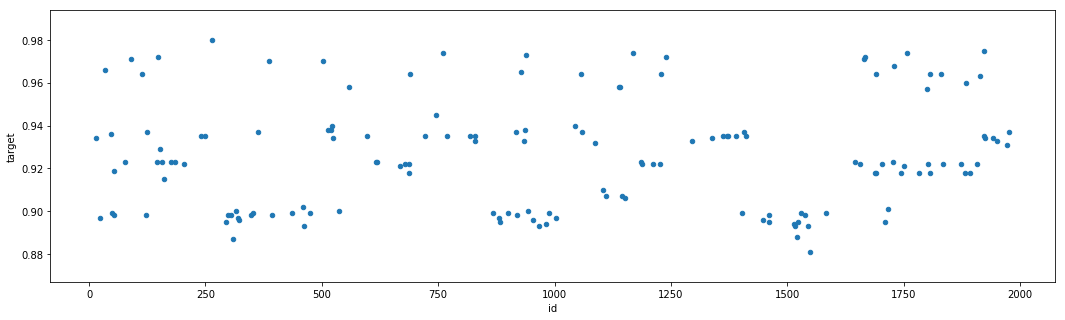

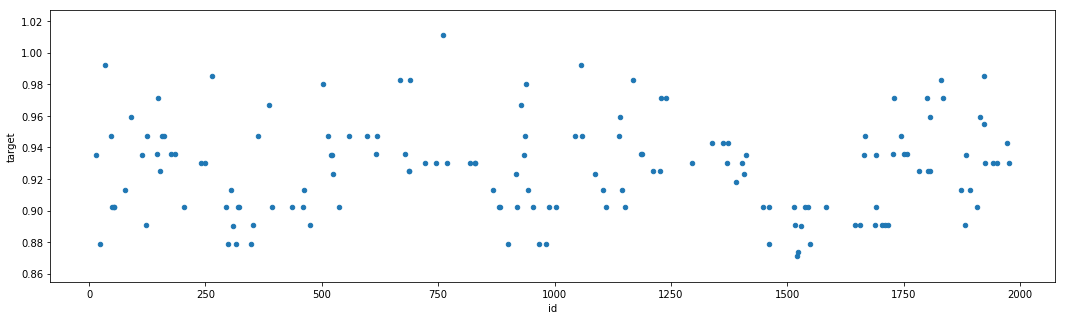

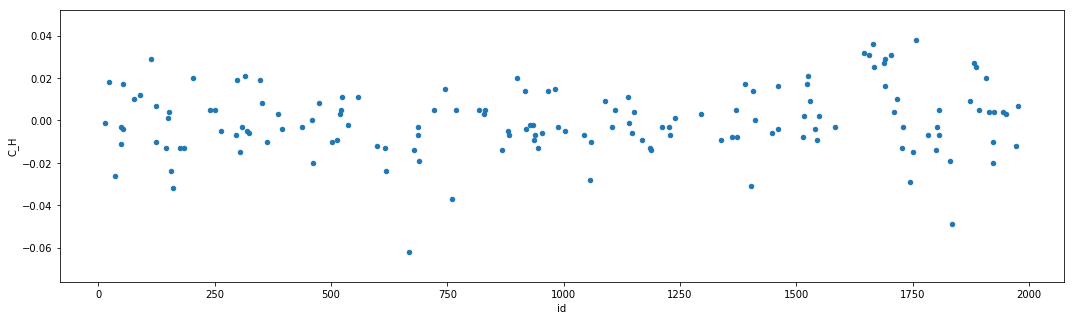

In [298]:
plt_point_A_B(current, 'id', 'target')
plt_point_A_B(history, 'id', 'target')
plt_point_A_B(current, 'id', 'C_H')

In [299]:
X_train, y_train, X_test, test_idx, min_max_scaler = split_data(pipe_data, min_max_scaler=min_max_scaler)

oof_lgb, predictions_lgb, lgb_models = lgb_predict(X_train, y_train, X_test,
                                       params=lgb_best_params, verbose_eval=None) 

In [300]:
X_train, y_train, X_test, test_idx, min_max_scaler = split_data(pipe_data, min_max_scaler=min_max_scaler)

oof_xgb, predictions_xgb, xgb_models = xgb_predict(X_train, y_train, X_test,
                                       params=xgb_best_params, verbose_eval=None) 

In [201]:
mean_squared_error(predictions_xgb, history['target'])/2

0.0001296213802928343

In [202]:
mean_squared_error(predictions_lgb, history['target'])/2

0.00012866517569178282

In [203]:
mean_squared_error((predictions_lgb+predictions_xgb)/2, history['target'])/2

0.00012887662537424538

In [204]:
mean_squared_error(predictions, history['target'])/2

0.00012964694092158554

In [301]:
mean_squared_error(current['target'], history['target'])/2

0.00012184136666666669

In [295]:
current.loc[np.abs(current['C_H']) > 0.05]

,id,target,C_H
4,443,0.898,0.176
23,1602,0.940,0.061
28,1596,0.896,-0.051
81,1039,0.896,-0.051


In [296]:
full[full['id'].apply(lambda x: x in current.loc[np.abs(current['C_H']) > 0.05, ['id']].values)]

,A1,A10,A11,A12,A13,A14,A15,A16,A17,A18,A19,A2,A20,A21,A22,A23,A24,A25,A26,A27,A28,A3,A4,A5,A6,A7,A8,A9,B1,B10,B11,B12,B13,B14,B2,B3,B4,B5,B6,B7,B8,B9,id,target


In [126]:
pipe_data[pipe_data['id'].apply(lambda x: x in current.loc[np.abs(current['C_H']) > 0.03, ['id']].values)]

KeyError: 'id'

# 日志

## 1-27

+ __更改代码：__

特征预测和后向特征选择改用 lgb，速度和准确率均上升。

初始特征增加 B12

+ __特征选择：__

初始 CV：11612

剩余特征： A6, A16, B11_null, B14, B14/B12, id（6个特征）

最后三次 CV：11456, 11383, 11409

+ __结果：__

lgb： 11123

xgb： 11264

融合： 11066

## 1-29

+ __更改代码：__

（1）增加生成最优参数部分，将原有的 lgb、xgb 和 stacking 进行合并， 改为函数： train_predict。

（2）保存了每个部分的模型用来预测用，即评估函数。

（3）尝试了两种方法，梯度下降和粒子群，梯度下降效果特别差，有可能是梯度不连续，或者优化方法不对；粒子群效果较好，可以自动选择参数，但是经过测试发现最优参数随机性较大，猜测应该是随机数种子造成，与参数关系不是特别大。

+ __需要改进的地方：__

（1）在 pipe line 中需要增加不需要的特征这一变量，然后每个步骤根据需要的特征和不需要的特征来筛选出初始特征。

（2）预测特征时应该尽量避免使用测试集，因为不同的测试集导致模型不同，继而最后选出的最优参数也不一样，但是最后提交的是固定的最优参数，所以需要保证模型也是一样的，最优参数仍然是最优的。

## 2-21

+ __更改代码：__
（1）改进上述需要改进的（1）
（2）保存生成模型
（3）特征后向选择部分修复错误，原程序只保存了特征没保存顺序，现在特征和顺序都保存
（4）最终程序直接使用选择后的特征，不再后向查找

+ __特征选择：__

pipe_line:
selected_features = ['A22', 'A28', 'A20_end', 'B10', 'B11_start', 'A5', 'A10', 'B14/B12', 'B14']
unused_features = ['id', 'target']

pipe = Pipeline([
                ('del_nan_feature', del_nan_feature()),
                ('handle_time_str', handle_time_str()),
                ('calc_time_diff', calc_time_diff()),
                ('Handle_outliers', handle_outliers(3)),
                ('del_single_feature', del_single_feature(1)),
                ('add_new_features', add_new_features()),
                ])

选择特征：['A22', 'A28', 'A20_end', 'B10', 'B11_start', 'A5', 'A10',  'B14/B12', 'B14']

+ __结果：__

lgb : 0.0001741102887004195

xgb : 0.00017517150996785284

融合 : 0.00017379917336479318

+ __需要改进：__
（1）同上（2）
（2）预测的参数可能会被当做异常值删除。